In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gams import *

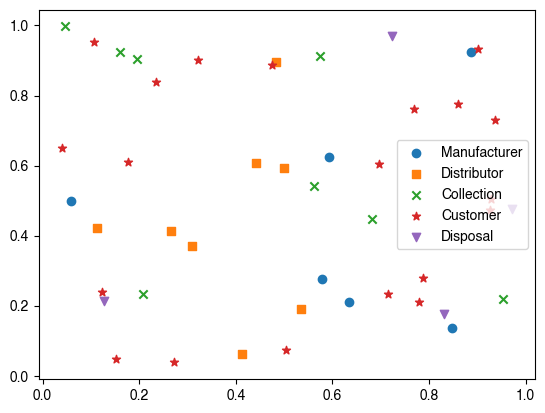

In [14]:
I_COUNT = 6 # Potential locations of (re)manufacturing centers
J_COUNT = 8 # Potential locations of distribution centers
K_COUNT = 20 # Fixed locations of retailers
C_COUNT = 8 # Potential locations of collection centers
D_COUNT = 4 # Fixed locations of disposal centers
T_COUNT = 8 # Set of time periods in the planning horizon
S_COUNT = 4 # Set of possible scenarios

# Transportation costs
I_loc = np.random.uniform(low = 0, high = 1, size = (I_COUNT, 2))
J_loc = np.random.uniform(low = 0, high = 1, size = (J_COUNT, 2))
C_loc = np.random.uniform(low = 0, high = 1, size = (C_COUNT, 2))
K_loc = np.random.uniform(low = 0, high = 1, size = (K_COUNT, 2))
D_loc = np.random.uniform(low = 0, high = 1, size = (D_COUNT, 2))

plt.scatter(I_loc[:, 0], I_loc[:, 1], marker = "o", label = "Manufacturer")
plt.scatter(J_loc[:, 0], J_loc[:, 1], marker = "s", label = "Distributor")
plt.scatter(C_loc[:, 0], C_loc[:, 1], marker = "x", label = "Collection")
plt.scatter(K_loc[:, 0], K_loc[:, 1], marker = "*", label = "Customer")
plt.scatter(D_loc[:, 0], D_loc[:, 1], marker = "v", label = "Disposal")

plt.legend()

distJJ = np.zeros((J_COUNT, J_COUNT))
distCC = np.zeros((C_COUNT, C_COUNT))
distIJ = np.zeros((I_COUNT, J_COUNT))
distJK = np.zeros((J_COUNT, K_COUNT))
distKC = np.zeros((K_COUNT, C_COUNT))
distCI = np.zeros((C_COUNT, I_COUNT))
distCD = np.zeros((C_COUNT, D_COUNT))

for j in range(J_COUNT):
    for j_ in range(J_COUNT):
        distJJ[j, j_] = np.random.uniform(np.linalg.norm(J_loc[j] - J_loc[j_], ord = 2), np.linalg.norm(J_loc[j] - J_loc[j_], ord = 1))
for c in range(C_COUNT):
    for c_ in range(C_COUNT):
        distCC[c, c_] = np.random.uniform(np.linalg.norm(C_loc[c] - C_loc[c_], ord = 2), np.linalg.norm(C_loc[c] - C_loc[c_], ord = 1))
for i in range(I_COUNT):
    for j in range(J_COUNT):
        distIJ[i, j] = np.random.uniform(np.linalg.norm(I_loc[i] - J_loc[j], ord = 2), np.linalg.norm(I_loc[i] - J_loc[j], ord = 1))
for j in range(J_COUNT):
    for k in range(K_COUNT):
        distJK[j, k] = np.random.uniform(np.linalg.norm(J_loc[j] - K_loc[k], ord = 2), np.linalg.norm(J_loc[j] - K_loc[k], ord = 1))
for k in range(K_COUNT):
    for c in range(C_COUNT):
        distKC[k, c] = np.random.uniform(np.linalg.norm(K_loc[k] - C_loc[c], ord = 2), np.linalg.norm(K_loc[k] - C_loc[c], ord = 1))
for c in range(C_COUNT):
    for d in range(D_COUNT):
        distCD[c, d] = np.random.uniform(np.linalg.norm(C_loc[c] - D_loc[d], ord = 2), np.linalg.norm(C_loc[c] - D_loc[d], ord = 1))
for c in range(C_COUNT):
    for i in range(I_COUNT):
        distCI[c, i] = np.random.uniform(np.linalg.norm(C_loc[c] - I_loc[i], ord = 2), np.linalg.norm(C_loc[c] - I_loc[i], ord = 1))

In [15]:
Dem_nom = np.zeros((K_COUNT, T_COUNT))
Dem_mat = np.zeros((K_COUNT, T_COUNT, S_COUNT))

for k in range(K_COUNT):
    for t in range(T_COUNT):
        Dem_nom[k, t] = 2500 * np.abs(0.5 + 0.2 * (K_loc[k, 0] - 0.5) * (t - 1) / (T_COUNT - 1) + 0.2 * (0.5 - K_loc[k, 0]) * (T_COUNT - t) / (T_COUNT - 1))
#        Dem_nom[k, t] = 1500
for k in range(K_COUNT):
    for t in range(T_COUNT):
        for s in range(S_COUNT):
            Dem_mat[k, t, s] = np.random.uniform(low = 0.5 * Dem_nom[k, t], high = 1.5 * Dem_nom[k, t])
""" Dem_mask = (np.array(K_loc[:, 0] > 0.5).astype(np.float64) + 0.5).reshape((-1, 1)) * (np.array(np.arange(0, T_COUNT) % 2 == 0).astype(np.float64) + 0.5).reshape((1, -1))
Dem_mat = Dem_mat * np.expand_dims(Dem_mask, axis = 2) """
Ret_mat = Dem_mat * np.random.uniform(low = 0.2, high = 0.4, size = (K_COUNT, T_COUNT, S_COUNT))

TrIJ_mat = distIJ * 20
TrJK_mat = distJK * 60
TrKC_mat = distKC * 30
TrCI_mat = distCI * 10
TrCD_mat = distCD * 5 \

ModCostJ = np.random.uniform(2e5, 2.5e5, size = (J_COUNT, 1)) * np.array([pow(0.98, t) for t in range(T_COUNT)]).reshape((1, T_COUNT))
ModCostC = np.random.uniform(1e5, 1.25e5, size = (C_COUNT, 1)) * np.array([pow(0.98, t) for t in range(T_COUNT)]).reshape((1, T_COUNT))

RelocJ_mat = distJJ * np.random.uniform(3000, 3000, size = distJJ.shape)
RelocC_mat = distCC * np.random.uniform(2000, 2000, size = distCC.shape)

MaxModNumJ = 5
MaxModNumC = 5
ModSizeJ = 3000
ModSizeC = 2000

CapI = np.random.uniform(10000, 15000, size = I_COUNT)

ManCost_mat = np.random.uniform(20, 20, size = I_COUNT)
RemanCost_mat = np.random.uniform(8, 8, size = I_COUNT)
ColCost_mat = np.random.uniform(12, 12, size = C_COUNT)
DispCost_mat = np.random.uniform(6, 6, size = D_COUNT)
RemanFr_mat = np.random.uniform(0.5, 0.7, size = (K_COUNT, T_COUNT, S_COUNT))


In [16]:
import itertools

ws = GamsWorkspace("./")
db = ws.add_database() 

i_set = db.add_set("i", 1)
for i in range(1, I_COUNT + 1):
    i_set.add_record(str(i))
j_set = db.add_set("j", 1)
for j in range(1, J_COUNT + 1):
    j_set.add_record(str(j))
k_set = db.add_set("k", 1)
for k in range(1, K_COUNT + 1):
    k_set.add_record(str(k))
c_set = db.add_set("c", 1)
for c in range(1, C_COUNT + 1):
    c_set.add_record(str(c))
d_set = db.add_set("d", 1)
for d in range(1, D_COUNT + 1):
    d_set.add_record(str(d))
t_set = db.add_set("t", 1)
for t in range(1, T_COUNT + 1):
    t_set.add_record(str(t))
s_set = db.add_set("s", 1)
for s in range(1, S_COUNT + 1):
    s_set.add_record(str(s))

def gms_add_param(db : GamsDatabase, name : str, domains : list, data) -> GamsParameter:
    def _rangelen(gmsset):
        return list(range(len(gmsset)))

    param = db.add_parameter_dc(name, domains)
    if not domains:
        param.add_record([]).value = data
        return param

    for item in itertools.product(*list(map(_rangelen, domains))):
        if type(data) is np.ndarray:
            param.add_record(list(map(lambda x: str(x + 1), item))).value = data[item]
        else:
            param.add_record(list(map(lambda x: str(x + 1), item))).value = data
    return param

Dem_param = gms_add_param(db, "Dem", [k_set, t_set, s_set], Dem_mat)
Ret_param = gms_add_param(db, "Ret", [k_set, t_set, s_set], Ret_mat)
RemanFr_param = gms_add_param(db, "RemanFr", [k_set, t_set, s_set], RemanFr_mat)

Kloc_0_param = gms_add_param(db, "Kloc_0", [k_set], K_loc[:, 0])
Kloc_1_param = gms_add_param(db, "Kloc_1", [k_set], K_loc[:, 1])

TrIJ_param = gms_add_param(db, "TrCostIJ", [i_set, j_set], TrIJ_mat)
TrJK_param = gms_add_param(db, "TrCostJK", [j_set, k_set], TrJK_mat)
TrKC_param = gms_add_param(db, "TrCostKC", [k_set, c_set], TrKC_mat)
TrCI_param = gms_add_param(db, "TrCostCI", [c_set, i_set], TrCI_mat)
TrCD_param = gms_add_param(db, "TrCostCD", [c_set, d_set], TrCD_mat)

ModCostJ_param = gms_add_param(db, "ModCostJ", [j_set, t_set], ModCostJ)
ModCostC_param = gms_add_param(db, "ModCostC", [c_set, t_set], ModCostC)
MaxModNumJ_param = gms_add_param(db, "MaxModNumJ", [], MaxModNumJ)
MaxModNumC_param = gms_add_param(db, "MaxModNumC", [], MaxModNumC)
ModSizeJ_param = gms_add_param(db, "ModSizeJ", [], ModSizeJ)
ModSizeC_param = gms_add_param(db, "ModSizeC", [], ModSizeC)
RelocCostJ_param = gms_add_param(db, "RelocCostJ", [j_set, j_set], RelocJ_mat)
RelocCostC_param = gms_add_param(db, "RelocCostC", [c_set, c_set], RelocC_mat)

CapI_param = gms_add_param(db, "CapI", [i_set], CapI)

ManCost_param = gms_add_param(db, "ManCost", [i_set], ManCost_mat)
RemanCost_param = gms_add_param(db, "RemanCost", [i_set], RemanCost_mat)
ColCost_param = gms_add_param(db, "ColCost", [c_set], ColCost_mat)
DispCost_param = gms_add_param(db, "DispCost", [d_set], DispCost_mat)

db.export("data_delta0.2.gdx")